# Basic Workflow 1: Introduction to cyREST API

by [Keiichiro Ono](http://keiono.github.io/)

----

![](http://cytoscape.org/images/logo/cy3logoOrange.svg)


## Introduction
This is an introduction to cyREST and its API.  You will learn how to access Cytoscape via RESTful API.

### Prerequisites
* Basic knowledge of RESTful API
    * [This is a good introduction to REST](http://www.restapitutorial.com/)
* Basic Python skill
* Basic knowledge of Cytoscape

### System Requirments
* [Java 8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html)
* [Cytoscape 3.2.1 or later](http://cytoscape.org/download.php)
* Latest version of [cyREST app](http://apps.cytoscape.org/apps/cyrest)

#### Tested with Python 2.7.10 and 3.4.0.  You are running:

In [1]:
import sys
print ('My Python Version = ' + sys.version)

My Python Version = 2.7.10 |Anaconda 2.2.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)]


----
## Questions or Feature Requests?
Please send them to our [mailing list](https://groups.google.com/forum/#!forum/cytoscape-discuss)

## 1. Import Python Libraries and Basic Setup

### Libraries
In this tutorial, we will use several popular Python libraries to make this workflow more realistic.

#### HTTP Client
Since you need to access Cytoscape via RESTful API, HTTP client library is the most important tool you need to understand.  In this example, we use [Requests](http://docs.python-requests.org/en/latest/) library to simplify API call code.

#### JSON Encoding and Decoding
Data will be exchanged as JSON between Cytoscape and Python code.  Python has built-in support for JSON and we will use [it](https://docs.python.org/2/library/json.html) in this workflow.

### Basic Setup for the API
At this point, there is only one option for the cy-rest module: port number.

#### URL to Access Cytoscape REST API
We assume you are running Cytoscape desktop application and IPython Notebook server on a same machine.  To access Cytoscape REST API, use the following URL:

```
http://localhost:PORT_NUMBER/v1/
```

where __v1__ is the current version number of API.  Once the final release is ready, we guarantee compatibility of your scripts as long as major version number is the same.

##### Note
Of course, you can run Cytoscape and IPython server on different machines.  In that case, you need to change the URL to the machine running Cytoscape desktop.  Also, you need to open the port.

#### Change Port Number
By default, port number used by cyREST is __1234__.  To change this, you need set a global Cytoscape property from:

* _**Edit &rarr; Preserences &rarr; Properties...**_

and add a new property __resr.port__.

Before running following cells, install dependent Python packages with
```
pip install -U requests
```

In [2]:
# HTTP Client for Python
import requests

# Standard JSON library
import json

# Basic Setup
PORT_NUMBER = 1234

# Specify your machine's URL (The IP address of the machine running Cytoscape and cyREST) if you use 
# Docker or remote server for this notebook.
#IP = '192.168.1.1'

# If you are running both Notebook server and Cytoscape on a same machine, just use localhost
IP = 'localhost'

BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'

# Header for posting data to the server as JSON
HEADERS = {'Content-Type': 'application/json'}

## 2. Test Cytoscape REST API

### Understand REST Basics

| HTTP Verb | Description |
|:----------:|:------------|
| GET | Retrieving resources (in most cases, it is Cytoscape data objects, such as networks or tables) |
| POST | Creating resources | 
| PUT | Changing/replacing resources or collections |
| DELETE | Deleting resources |

----

### Check the status of server
First, send a simple request and check the server status.

In [3]:
# Get server status
res = requests.get(BASE)

### Roundtrip between JSON and Python Object

#### Introduction to JSON handling in Python


Now, __res__ object contains return value of API as JSON.  Let's convert it into Python object:

In [4]:
status_object = res.json();
print(json.dumps(status_object, indent=4))

{
    "memoryStatus": {
        "usedMemory": 356, 
        "freeMemory": 2546, 
        "maxMemory": 28217, 
        "totalMemory": 2903
    }, 
    "numberOfCores": 8, 
    "apiVersion": "v1"
}


JSON library in Python converts JSON string into simple Python object.

In [5]:
print(status_object['apiVersion'])
print(status_object['memoryStatus']['usedMemory'])

v1
356


If you are comfortable with this data type conversion, you are ready to go!

----
## 3. Import Networks from various data sources
There are many ways to load networks into Cytoscape from REST API:

* Load from files
* Load from web services
* Send Cytoscape.js style JSON directly to Cytoscape
* Send edgelist

### 3.1 Create networks from local files and URLs

Let's start from a simple file loading examples.  The __POST__ method is used to create new Cytoscape objects.  For example,

```bash
POST http://localhost:1234/v1/networks
```

means create new network(s) by specified method.  If you want to create networks from files on your machine or remote servers, all you need to do is create a list of file locations and post it to Cytoscape.

In [6]:
# Small utility function to create networks from list of URLs
def create_from_list(network_list):
    server_res = requests.post(BASE + 'networks?source=url&collection=Yeast Collection', data=json.dumps(network_list), headers=HEADERS)
    return server_res.json()

# This is not necessary if you directly specify absolute file path like "/Users/foo/bar/sample_data/yeast.json"
import os
filepath = os.path.abspath('sample_data/yeast.json')

import platform
if platform.system() != 'Windows':
    filepath = 'file://' + filepath  

print('Target Local File = ' + filepath)

Target Local File = file:///Users/kono/prog/git/cy-rest-python/basic/sample_data/yeast.json


## If you do understand what this code means, uncomment the line _filepath_.  Otherwise, don't try.  You need to know how to specify local file location as URL.

In [7]:
# Array of data source. 
network_files = [
    # Local file in this example data directory
    # filepath,

    # SIF file on a web server
    'http://chianti.ucsd.edu/cytoscape-data/galFiltered.sif'
    
    # And of course, you can add as many files as you need...
]

# Create!
print(json.dumps(create_from_list(network_files), indent=4))

[
    {
        "source": "http://chianti.ucsd.edu/cytoscape-data/galFiltered.sif", 
        "networkSUID": [
            52
        ]
    }
]


### 3.2 Create networks from public RESTful web services
There are many public network data services.  If the service supports Cytoscape-readable file formats, you can specify the query URL as a network location.  For example, the following URL calls [PSICQUIC](https://code.google.com/p/psicquic/) web service and returns the search result in PSIMI 2.5 XML format.  Since Cytoscape supports PSIMI2.5 files by default, this automatically creates a network from the response from the web service. 

In [8]:
# This may take a while because Cytoscape fetch the data from a server in UK...
queries = [ 'http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/brca1?format=xml25' ]
print(json.dumps(create_from_list(queries), indent=4))

[
    {
        "source": "http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/brca1?format=xml25", 
        "networkSUID": [
            1466
        ]
    }
]


And of course, you can mix local files, URLs, and list of web service queries in a same list:

In [9]:
mixed = [
    #'file://' + filepath,
    'http://chianti.ucsd.edu/cytoscape-data/galFiltered.sif',
    
    # Uncomment the line below if you have fast internet connection
    #'http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/brca2?format=xml25'
]
print(json.dumps(create_from_list(mixed), indent=4))

[
    {
        "source": "http://chianti.ucsd.edu/cytoscape-data/galFiltered.sif", 
        "networkSUID": [
            3038
        ]
    }
]


### 3.3 Create networks from Python objects
And this is the most powerful feature in Cytoscape REST API.  __You can easily convert Python objects into Cytoscape networks, tables, or Visual Styles__

#### How does this work?
Cytoscape REST API sends and receives data as JSON.  For networks, it uses [Cytoscape.js style JSON](http://cytoscape.github.io/cytoscape.js/) (support for more file formats are comming!).  You can programmatically generates networks by converting Python dictionary into JSON.

#### 3.3.1 Prepare Network as Cytoscape.js JSON
Let's start with the simplest network JSON:

In [10]:
# Start from a clean slate: remove all networks from current session
requests.delete(BASE + 'networks')

# Manually generates JSON as dictionary

empty_network = {
        'data': {
            'name': 'I\'m empty!'
        },
        'elements': {
            'nodes':[],
            'edges':[]
        }
}

res = requests.post(BASE + 'networks?collection=My%20Collection', data=json.dumps(empty_network), headers=HEADERS) 
net_suid = res.json()['networkSUID']
print('Empty network has SUID ' + str(net_suid))

Empty network has SUID 4452


Since it's a simple Python dictionary, it is easy to add data to the network.  Let's add some nodes and edges:

In [11]:
import copy

# Create a copy of the empty network object
small_network = copy.deepcopy(empty_network)

# Sequence of letters (a-z)
seq_letters = list(map(chr, range(ord('a'), ord('z')+1)))

# Build nodes and edges (in functional way)
build_node = lambda x: {'data': { 'id': x }}
abc_nodes = list(map(build_node, seq_letters))

build_edge = lambda x: {'data': { 'source': x, 'target': 'a' }}
rand_edges = list(map(build_edge, seq_letters))

small_network['elements']['nodes'] = abc_nodes
small_network['elements']['edges'] = rand_edges
small_network['data']['name'] = 'A is the hub.'

# Uncomment this if you want to see the actual JSON object
#print(json.dumps(small_network, indent=4))

res = requests.post(BASE + 'networks?collection=My%20Collection', data=json.dumps(small_network), headers=HEADERS)
res_dict = res.json()
new_suid = res_dict['networkSUID']

# Apply layout
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))

<Response [200]>

It's simple, isn't it?

### Embed images in IPython Notebook
cyRest has function to generate PNG image directly from current network view.  Let's try to see the result in this notebook.

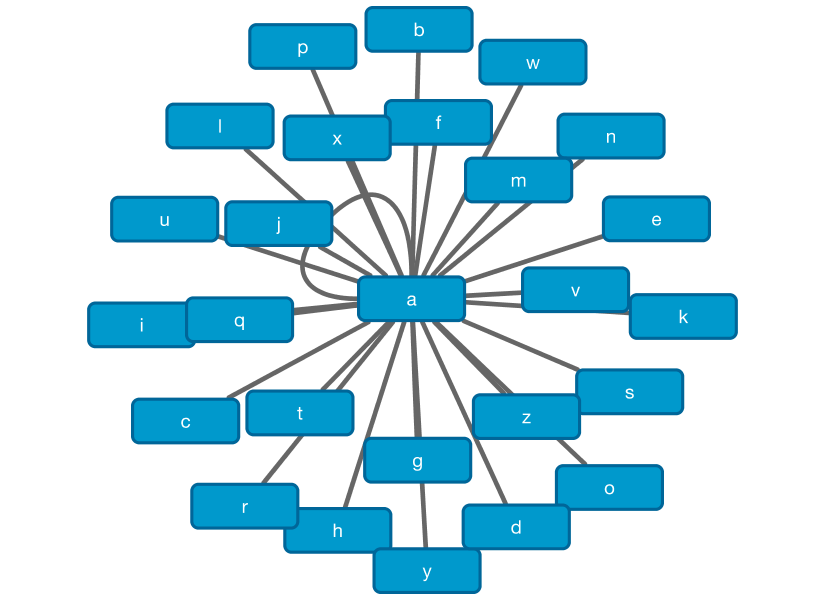

In [12]:
from IPython.display import Image
Image(url=BASE+'networks/' + str(new_suid) + '/views/first.png', embed=True)

#### 3.3.2 Prepare Network as edgelist
Edgelist is a minimalistic data format for networks and it is widely used in popular libraries including NetworkX and igraph.  Preparing edgelist in Python is straightforward.  You just need to prepare a list of edges as string like:

```
a b
b c
a c
```

In Python, there are many ways to generate string like this.  Here is a naive approach:

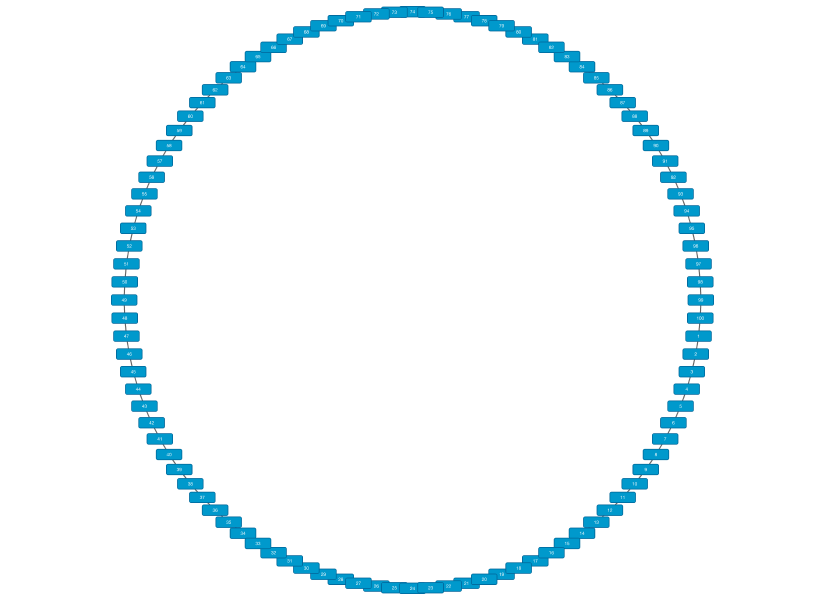

In [13]:
numbers = range(1,101)
el_builder = lambda x:  str(x) + '\t' + str(1) if x is 100 else str(x) + '\t' + str(x+1) + '\n'

el = list(map(el_builder, numbers))

edgelist = ''.join(el)

res = requests.post(BASE + 'networks?format=edgelist&collection=Ring', data=edgelist, headers=HEADERS)

res_dict = res.json()
circle_suid = res_dict['networkSUID']
requests.get(BASE + 'apply/layouts/circular/' + str(circle_suid))


Image(url=BASE+'networks/' + str(circle_suid) + '/views/first.png', embed=True)

# New in 1.x: PDF and SVG support
In addition to bitmap images, you can generate vector graphics including SVG and PDF!

http://localhost:1234/v1/networks/4596/views/first.svg


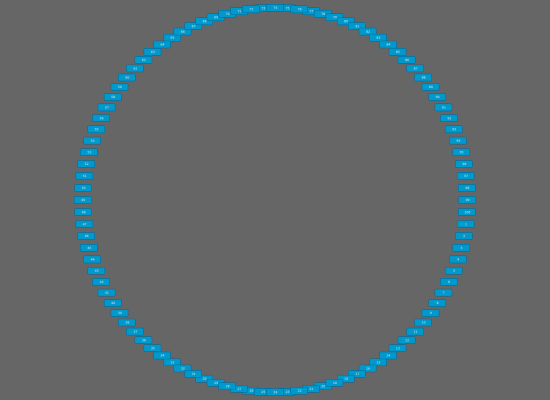

In [21]:
from IPython.core.display import SVG
svg_url = BASE+'networks/' + str(circle_suid) + '/views/first.svg'

print(svg_url)
SVG(url=svg_url)

In [20]:
# Generate PDF from the network and save it in current directory:

import urllib

pdf_url = BASE+'networks/' + str(circle_suid) + '/views/first.pdf'
print(pdf_url)

res = urllib.urlretrieve (pdf_url, "network.pdf")

http://localhost:1234/v1/networks/4596/views/first.pdf


## Discussion
In this section, we've learned how to generate networks programmatically from Python.  But for real world problems, it is not a good idea to use low level Python objects to generate networks because there are lots of cool libraries such as NetworkX or igraph.  In the next session, let's use those to analyze real network data and visualize them in Cytoscape.

----
[Back to Index](../index.ipynb)